In [1]:
# Disable some console warnings
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import sys 
sys.path.append('../training')
import pickle

from save_data import process_data

import hls4ml 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy

from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
import tensorflow_model_optimization as tfmot

from qkeras.qlayers import QDense, QActivation
from qkeras import QBatchNormalization
from qkeras.quantizers import quantized_bits, quantized_relu
from qkeras.utils import _add_supported_quantized_objects
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

import pandas as pd

# os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

## Configure

In [3]:
# START_WINDOW = 285
# END_WINDOW = 385

# START_WINDOW = 150
# END_WINDOW = 350

# START_WINDOW = 150
# END_WINDOW = 550

START_WINDOW = 0
END_WINDOW = 770

## Setup data

In [4]:
def one_hot_encode(data):
    y_encoded = np.zeros([data.shape[0],2], dtype=np.int32)
    for idx, x in enumerate(data):
        if x == 1:
            y_encoded[idx][1] = 1
        else:
            y_encoded[idx][0] = 1
    return y_encoded

In [5]:
!mkdir -p models

DATA_DIR = f'../data/qick_data/{START_WINDOW}_{END_WINDOW}'
MODEL_DIR = f'models/model_{START_WINDOW}_{END_WINDOW}'

# convert raw ADC data into npy files 
if os.path.exists(f'{DATA_DIR}/X_train_{START_WINDOW}_{END_WINDOW}.npy') == False:
    process_data(
        start_window=START_WINDOW, 
        end_window=END_WINDOW, 
        data_dir=DATA_DIR
    )

In [6]:
# load data
X_train_val = np.load(os.path.join(DATA_DIR, f'X_train_{START_WINDOW}_{END_WINDOW}.npy'))
X_test = np.load(os.path.join(DATA_DIR, f'X_test_{START_WINDOW}_{END_WINDOW}.npy'))    
y_train_val = np.load(os.path.join(DATA_DIR, f'y_train_{START_WINDOW}_{END_WINDOW}.npy'))
y_test = np.load(os.path.join(DATA_DIR, f'y_test_{START_WINDOW}_{END_WINDOW}.npy'))

y_train_val = one_hot_encode(y_train_val)
y_test = one_hot_encode(y_test)

print('Window:')
print('  - Couples I/Q :', (END_WINDOW-START_WINDOW))
print('  - Model inputs:', (END_WINDOW-START_WINDOW)*2)

print('Training:')
print('  - Size        :', X_train_val.shape[0])
print('  - Sample Shape:', X_train_val.shape[1])
print('  - Mean        :', X_train_val.mean())
print('  - Std. Dev.   :', X_train_val.std())

print('Testing:')
print('  - Size        :', X_test.shape[0])
print('  - Sample Shape:', X_test.shape[1])
print('  - Mean        :', X_test.mean())
print('  - Std. Dev.   :', X_test.std())

assert len(X_train_val[0]) == (END_WINDOW-START_WINDOW)*2, 'ERROR: Specified window does not match loaded dataset shape'
assert len(X_test[0]) == (END_WINDOW-START_WINDOW)*2, 'ERROR: Specified window does not match loaded dataset shape'

Window:
  - Couples I/Q : 770
  - Model inputs: 1540
Training:
  - Size        : 909000
  - Sample Shape: 1540
  - Mean        : -50.80006179189348
  - Std. Dev.   : 1757.8248912271774
Testing:
  - Size        : 101000
  - Sample Shape: 1540
  - Mean        : -44.14494603317475
  - Std. Dev.   : 1756.0220686228422


## Load model

In [7]:
MODEL_FILENAME = MODEL_DIR + f'/qmodel_{START_WINDOW}_{END_WINDOW}.h5'

In [8]:
co = {}
_add_supported_quantized_objects(co)
model = load_model(MODEL_FILENAME, custom_objects=co, compile=False)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [9]:
print('=============================Model Summary=============================')
print(model.summary())
print('=======================================================================')

=============================Model Summary=============================
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (QDense)                (None, 2)                 3082      
                                                                 
 batch_normalization (BatchN  (None, 2)                8         
 ormalization)                                                   
                                                                 
Total params: 3,090
Trainable params: 3,086
Non-trainable params: 4
_________________________________________________________________
None


In [10]:
y_pred = model.predict(X_test)
print('Keras accuracy: {}, inputs {}, I/Qs {}'.format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)), (END_WINDOW-START_WINDOW)*2, (END_WINDOW-START_WINDOW)))

3157/3157 [==============================] - 2s 676us/step
Keras accuracy: 0.9614851485148515, inputs 1540, I/Qs 770


If you run with the model and data on files, you should expect
```
Keras accuracy: 0.9614851485148515, inputs 1540, I/Qs 770
Keras accuracy: 0.9535643564356435, inputs 800, I/Qs 400
Keras accuracy: 0.9291980198019802, inputs 400, I/Qs 200
Keras accuracy: 0.8572376237623762, inputs 200, I/Qs 100
```

### Check model accuracy on FPGA traces

In [11]:
!ls ../data/fpga_testing

malab_e_state_A_fpga.csv  malab_g_state_A_fpga.csv  README.md


#### Load CSV files from board runs

In [12]:
DATA_FPGA_DIR = '../data/fpga_testing'

df = pd.read_csv(DATA_FPGA_DIR + '/malab_g_state_A_fpga.csv', header=None)
X_g_test_board = df.values

df = pd.read_csv(DATA_FPGA_DIR + '/malab_e_state_A_fpga.csv', header=None)
X_e_test_board = df.values

#### Standard windows

(1, 2, 770)


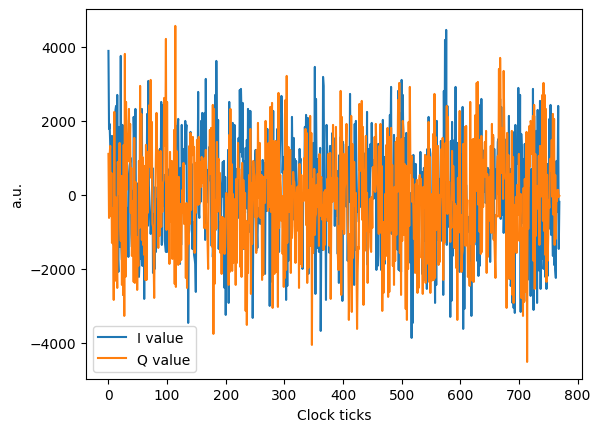

In [13]:
iq_list = X_e_test_board[0].reshape(1, 2, -1)
print(iq_list.shape)

# Plot results.
plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value")
    plt.plot(iq[1], label="Q value")
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
# plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()

In [14]:
y_g_qkeras_pred = model.predict(X_g_test_board[:,START_WINDOW*2:END_WINDOW*2])
y_e_qkeras_pred = model.predict(X_e_test_board[:,START_WINDOW*2:END_WINDOW*2])

157/157 [==============================] - 0s 833us/step


In [15]:
logit_g_errors = 0
logit_e_errors = 0

test_g_size = y_g_qkeras_pred.shape[0]
for i in range(test_g_size):
    mismatch = y_g_qkeras_pred[i][0] < y_g_qkeras_pred[i][1]
    if (mismatch):
        logit_g_errors = logit_g_errors + 1

test_e_size = y_e_qkeras_pred.shape[0]
for i in range(test_e_size):
    mismatch = y_e_qkeras_pred[i][0] > y_e_qkeras_pred[i][1]
    if (mismatch):
        logit_e_errors = logit_e_errors + 1

In [16]:
logit_g_error_rate = (logit_g_errors * 100.) / test_g_size
acccuracy_g = 100. - logit_g_error_rate
print('Logit errors (ground): {:d}/{:d} ({:.2f}%)'.format(logit_g_errors, test_g_size, logit_g_error_rate))
print('Accuracy     (ground): {:.2f}%'.format(acccuracy_g))

Logit errors (ground): 99/5000 (1.98%)
Accuracy     (ground): 98.02%


In [17]:
logit_e_error_rate = (logit_e_errors * 100.) / test_e_size
acccuracy_e = 100. - logit_e_error_rate
print('Logit errors (excited): {:d}/{:d} ({:.2f}%)'.format(logit_e_errors, test_e_size, logit_e_error_rate))
print('Accuracy     (excited): {:.2f}%'.format(acccuracy_e))

Logit errors (excited): 292/5000 (5.84%)
Accuracy     (excited): 94.16%


In [18]:
test_size = test_g_size + test_e_size
logit_errors = logit_g_errors + logit_e_errors
logit_error_rate = (logit_errors * 100.) / test_size
acccuracy = 100. - logit_error_rate
print('Logit errors (average): {:d}/{:d} ({:.2f}%)'.format(logit_errors, test_size, logit_error_rate))
print('Accuracy     (average): {:.2f}%'.format(acccuracy))

Logit errors (average): 391/10000 (3.91%)
Accuracy     (average): 96.09%


#### Shifted windows

In [19]:
SHIFT_OFFSET = 8
SHIFT_L_OR_R = 'L' #'R'

In [20]:
def l_shift_data(X, start, end, offset):
    extended_X = np.pad(X, pad_width=((0, 0), (0, offset*2)), mode='constant', constant_values=0)
    return extended_X[:,(start+offset)*2:(end+offset)*2]

def r_shift_data(X, start, end, offset):
    extended_X = np.pad(X, pad_width=((0, 0), (offset*2, 0)), mode='constant', constant_values=0)
    return extended_X[:,(start+offset)*2:(end+offset)*2]

In [21]:
if SHIFT_L_OR_R == 'L':
    shifted_g_data = l_shift_data(X_g_test_board, START_WINDOW, END_WINDOW, SHIFT_OFFSET)
    shifted_e_data = l_shift_data(X_e_test_board, START_WINDOW, END_WINDOW, SHIFT_OFFSET)
else # R
    shifted_g_data = r_shift_data(X_g_test_board, START_WINDOW, END_WINDOW, SHIFT_OFFSET)
    shifted_e_data = r_shift_data(X_e_test_board, START_WINDOW, END_WINDOW, SHIFT_OFFSET)

y_g_qkeras_pred = model.predict(shifted_g_data)
y_e_qkeras_pred = model.predict(shifted_e_data)

157/157 [==============================] - 0s 823us/step


In [22]:
logit_g_errors = 0
logit_e_errors = 0

test_g_size = y_g_qkeras_pred.shape[0]
for i in range(test_g_size):
    mismatch = y_g_qkeras_pred[i][0] < y_g_qkeras_pred[i][1]
    if (mismatch):
        logit_g_errors = logit_g_errors + 1

test_e_size = y_e_qkeras_pred.shape[0]
for i in range(test_e_size):
    mismatch = y_e_qkeras_pred[i][0] > y_e_qkeras_pred[i][1]
    if (mismatch):
        logit_e_errors = logit_e_errors + 1

In [23]:
logit_g_error_rate = (logit_g_errors * 100.) / test_g_size
acccuracy_g = 100. - logit_g_error_rate
print('Logit errors (ground): {:d}/{:d} ({:.2f}%)'.format(logit_g_errors, test_g_size, logit_g_error_rate))
print('Accuracy     (ground): {:.2f}%'.format(acccuracy_g))

Logit errors (ground): 99/5000 (1.98%)
Accuracy     (ground): 98.02%


In [24]:
logit_e_error_rate = (logit_e_errors * 100.) / test_e_size
acccuracy_e = 100. - logit_e_error_rate
print('Logit errors (excited): {:d}/{:d} ({:.2f}%)'.format(logit_e_errors, test_e_size, logit_e_error_rate))
print('Accuracy     (excited): {:.2f}%'.format(acccuracy_e))

Logit errors (excited): 292/5000 (5.84%)
Accuracy     (excited): 94.16%


In [25]:
test_size = test_g_size + test_e_size
logit_errors = logit_g_errors + logit_e_errors
logit_error_rate = (logit_errors * 100.) / test_size
acccuracy = 100. - logit_error_rate
print('Logit errors (average): {:d}/{:d} ({:.2f}%)'.format(logit_errors, test_size, logit_error_rate))
print('Accuracy     (average): {:.2f}%'.format(acccuracy))

Logit errors (average): 391/10000 (3.91%)
Accuracy     (average): 96.09%
